Version info
>v011 - deleted testing codes

>v013 - manipulating multiple beta

>v014 - Handling missing data

>v015 - Error fixing of v014

>v016 - Simplified version of v015

>v017 - I gave up fixing bug, and I'll impute missing values with another way

>Converting this version to [test - PyMC3 - Missing value imputation idea]

>v018 - Here we apply imputation idea just figured out in the last version.

### Environment setting

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

import pymc3 as pm
import scipy.optimize as so

import datetime as dt

#from pymc3 import Model, sample, find_MAP, summary
#from pymc3 import NUTS, Metropolis, Slice
#from pymc3 import Normal, Uniform
#from scipy import optimize
#from pymc3 import traceplot

Using gpu device 0: GeForce GTX 750 (CNMeM is disabled)


In [4]:
debug = False

In [3]:
debug = True

### Preparing data

Loading and preprocessing barley data(explatory variables)

In [8]:
#Loading data file
#barley_raw = pd.read_csv('./data/barley_01.csv', sep=',', header=0, index_col=0)
barley_raw = pd.read_table('./data/barley_01.txt', sep='\t', header=0, index_col=0)

#Explorering data
if debug:
    barley_raw.head()
    barley_raw.info()

#Transposing
barley_t = barley_raw.transpose()
if debug:
    print(barley_t.iloc[0:5, 0:5])

# 39, 96, 116, 103 th DH lines removed for marker mapping(146 marker mappings)
# and also 33 th DH line should be removed for QTL analysis(145 lines)
barley = barley_t.drop(labels=barley_t.index[[39-1, 96-1, 116-1, 103-1, 33-1]])

barley.head()

#Imputed missing(-) to 1 temporarily, I'll use automatic imputation feature of PyMC
#[http://stronginference.com/missing-data-imputation.html]
#barley.replace(['A', 'B', '-'], [0,1,1], inplace=True)
barley.replace(['A', 'B', '-'], [0,1,-999], inplace=True)
#barley.replace(['A', 'B', '-'], [0,1,1], inplace=True)

barley_arr = np.array(barley)

if debug:
    print(barley.ix[:6,10:20])

Masking missing data that is '-999'

In [27]:
barley_arr_masked = np.ma.masked_array(barley_arr, mask=barley_arr==-999)
barley_arr_masked[:5,15:20]
#help(np.ma.masked_array)

masked_array(data =
 [[0 0 1 1 1]
 [1 -- 1 1 1]
 [-- 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]],
             mask =
 [[False False False False False]
 [False  True False False False]
 [ True False False False False]
 [False False False False False]
 [False False False False False]],
       fill_value = 999999)

Loading and preprocessing heading data(response variable)

In [26]:
heading_raw = pd.read_table('./data/HED_01.txt', sep='\t', header=0, index_col=0)
heading_raw.replace([-9999.0, -9999], [float('NaN'), float('NaN')], inplace=True)
if debug:
    print(heading_raw.head())
    
# Averaging 'days to heading' over all environments for each line.
heading = heading_raw.mean(skipna=True)
if debug:
    heading.head()



### Missing value imputation

First, generate random numbers for missing values

In [164]:
X_masked = barley_arr_masked[:40, :19]
X_masked[X_masked.mask == True]
X_masked

masked_array(data =
 [[1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 -- 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 -- 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 -- 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 -- 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 -- 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 -- 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 -- 1 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 -- 1 1 1]
 [1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 -- 1 1 1]
 [1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 -- 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 -- 1 1 1]
 [1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 -- 0 0 0 0 0 

In [165]:
niter = 10000
imp_model = pm.Model()
with imp_model:
    # refer to [https://github.com/pymc-devs/pymc3/blob/58f3f8e5d2a55edc5e05b33b239fa46631eff895/pymc3/examples/lasso_missing.py]
    #p_imp = pm.Beta('p_imp', 1, 1)
    #for i in range(num_p):
    #    X_imp[i] = pm.Bernoulli('X_imp' + str(i), p_imp, observed=np.ma.masked_values(X_masked[:,i], value=-999))
    p_imp = pm.Beta('p_imp', 1, 1)
    X_imp = pm.Bernoulli('X_imp', p_imp, observed=np.ma.masked_values(X_masked, value=-999))
    

Assigned <class 'pymc3.step_methods.nuts.NUTS'> to p_imp_logodds
Assigned <class 'pymc3.step_methods.metropolis.Metropolis'> to X_imp_missing
 [-----------------100%-----------------] 10000 of 10000 complete in 5.0 sec

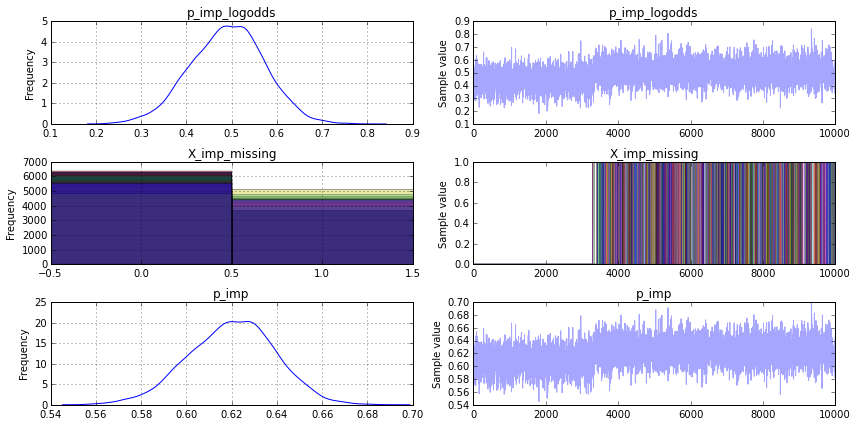

In [166]:
with imp_model:
    # Obtaining starting values via MAP
    start = pm.find_MAP()

    # Draw samples from posterior
    trace = pm.sample(niter, start=start, random_seed=2015, progressbar=True)
    
    # Ploting samples
    pm.traceplot(trace)

In [168]:
imp_val = np.round(np.mean(trace.get_values('X_imp_missing'),axis=0))

In [169]:
imp_val

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.])

In [182]:
test = trace.get_values('X_imp_missing')
sum(test == 0)

array([5492, 5806, 6366, 5934, 6270, 5719, 5337, 6290, 5452, 6194, 5213,
       5678, 5600, 5920, 5593, 6118, 5747, 6044, 5572, 4837, 6300, 5526])

In [185]:
print("Number of zero : ", np.sum(test == 0, axis=None))
print("Number of one  : ", np.sum(test == 1, axis=None))


Number of zero :  127008
Number of one  :  92992
